# 🤔 Text Classification active learning with ModAL

In this tutorial, we will walk through the process of building an active learning prototype with *Argilla*, [ModAL](https://modal-python.github.io/) and [scikit-learn](https://scikit-learn.org/).

- 💻 We train a spam filter using the YouTube Spam Collection data set.
- 🎩 For this we embed a lightweight scikit-learn classifier in an active learner via ModAL.
- 🏆 We design an active learning loop around *Argilla*, to quickly build up a training data set from scratch.


![training-textclassification-modal-activelearning](../../_static/tutorials/training-textclassification-modal-activelearning/training-textclassification-modal-activelearning.png)

## Introduction

> *Active learning is a special case of machine learning in which a learning algorithm can interactively query a user (or some other information source) to label new data points with the desired outputs. In statistics literature, it is sometimes also called optimal experimental design. The information source is also called teacher or oracle.* [[Wikipedia]](https://en.wikipedia.org/wiki/Active_learning_(machine_learning))

In this tutorial **our goal is to show you how to incorporate Argilla into an active learning workflow involving a human in the loop**.
We will build a simple text classifier by combining **scikit-learn**, the active learning framework **ModAL** and **Argilla**. 
Scikit-learn will provide the model that we will embed in an active learner from ModAL, and you and *Argilla* will serve as the information source that teaches the model to become a sample efficient classifier.

This tutorial is only a proof of concept for educational purposes and to inspire you with some ideas involving interactive learning processes, and how they can help to quickly build a training data set from scratch. 

## Running Argilla

For this tutorial, you will need to have an Argilla server running. There are two main options for deploying and running Argilla:


**Deploy Argilla on Hugging Face Spaces**: If you want to run tutorials with external notebooks (e.g., Google Colab) and you have an account on Hugging Face, you can deploy Argilla on Spaces with a few clicks:

[![deploy on spaces](https://huggingface.co/datasets/huggingface/badges/raw/main/deploy-to-spaces-lg.svg)](https://huggingface.co/new-space?template=argilla/argilla-template-space)

For details about configuring your deployment, check the [official Hugging Face Hub guide](https://huggingface.co/docs/hub/spaces-sdks-docker-argilla).


**Launch Argilla using Argilla's quickstart Docker image**: This is the recommended option if you want [Argilla running on your local machine](../../getting_started/quickstart.ipynb). Note that this option will only let you run the tutorial locally and not with an external notebook service.

For more information on deployment options, please check the Deployment section of the documentation.

<div class="alert alert-info">

Tip
    
This tutorial is a Jupyter Notebook. There are two options to run it:

- Use the Open in Colab button at the top of this page. This option allows you to run the notebook directly on Google Colab. Don't forget to change the runtime type to GPU for faster model training and inference.
- Download the .ipynb file by clicking on the View source link at the top of the page. This option allows you to download the notebook and run it on your local machine or on a Jupyter Notebook tool of your choice.
</div>

In [ ]:
%pip install argilla modAL scikit-learn matplotlib -qqq  # matplotlib is optional

Let's import the Argilla module for reading and writing data:

In [ ]:
import argilla as rg

If you are running Argilla using the Docker quickstart image or Hugging Face Spaces, you need to init the Argilla client with the `URL` and `API_KEY`:

In [ ]:
# Replace api_url with the url to your HF Spaces URL if using Spaces
# Replace api_key if you configured a custom API key
# Replace workspace with the name of your workspace
rg.init(api_url="http://localhost:6900", api_key="owner.apikey", workspace="admin")

If you're running a private Hugging Face Space, you will also need to set the [HF_TOKEN](https://huggingface.co/settings/tokens) as follows:

In [ ]:
# # Set the HF_TOKEN environment variable
# import os
# os.environ['HF_TOKEN'] = "your-hf-token"

# # Replace api_url with the url to your HF Spaces URL
# # Replace api_key if you configured a custom API key
# # Replace workspace with the name of your workspace
# rg.init(
#     api_url="https://[your-owner-name]-[your_space_name].hf.space",
#     api_key="owner.apikey",
#     workspace="admin",
#     extra_headers={"Authorization": f"Bearer {os.environ['HF_TOKEN']}"},
# )

Finally, let's include the imports we need:

In [ ]:
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.exceptions import NotFittedError
from sklearn.feature_extraction.text import CountVectorizer
from modAL.models import ActiveLearner
import matplotlib.pyplot as plt
import numpy as np
from urllib import request
from pathlib import Path
from tempfile import TemporaryDirectory

### Enable Telemetry

We gain valuable insights from how you interact with our tutorials. To improve ourselves in offering you the most suitable content, using the following lines of code will help us understand that this tutorial is serving you effectively. Though this is entirely anonymous, you can choose to skip this step if you prefer. For more info, please check out the [Telemetry](../../reference/telemetry.md) page.

In [ ]:
try:
    from argilla.utils.telemetry import tutorial_running

    tutorial_running()
except ImportError:
    print(
        "Telemetry is introduced in Argilla 1.20.0 and not found in the current installation. Skipping telemetry."
    )

## 1. Loading and preparing data

Argilla allows you to log and track data for different NLP tasks, such as `Token Classification` or `Text Classification`.

In this tutorial, we will use the [YouTube Spam Collection](http://www.dt.fee.unicamp.br/~tiago//youtubespamcollection/) dataset, which is a binary classification task for detecting spam comments in YouTube videos.

Let's load the data and have a look at it:

In [1]:
train_df = pd.read_csv("data/active_learning/train.csv")
test_df = pd.read_csv("data/active_learning/test.csv")

In [2]:
test_df

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,VIDEO
0,z120djlhizeksdulo23mj5z52vjmxlhrk04,Murlock Nightcrawler,2015-05-24T07:04:29.844000,Charlie from LOST?﻿,0,3
1,z133ibkihkmaj3bfq22rilaxmp2yt54nb,Debora Favacho (Debora Sparkle),2015-05-21T14:08:41.338000,BEST SONG EVER X3333333333﻿,0,4
2,z12gxdortqzwhhqas04cfjrwituzghb5tvk0k,Muhammad Asim Mansha,NaN,Aslamu Lykum... From Pakistan﻿,1,3
3,_2viQ_Qnc6_ZYkMn1fS805Z6oy8ImeO6pSjMLAlwYfM,mile panika,2013-11-03T14:39:42.248000,I absolutely adore watching football plus I’ve...,1,4
4,z120s1agtmmetler404cifqbxzvdx15idtw0k,Sheila Cenabre,2014-08-19T12:33:11,I really love this video.. http://www.bubblews...,1,1
...,...,...,...,...,...,...
387,z13pup2w2k3rz1lxl04cf1a5qzavgvv51vg0k,geraldine lopez,2015-05-20T23:44:25.920000,love the you lie the good﻿,0,3
388,z13psdarpuzbjp1hh04cjfwgzonextlhf1w,bilal bilo,2015-05-22T20:36:36.926000,I liked<br />﻿,0,4
389,z131xnwierifxxkj204cgvjxyo3oydb42r40k,YULIOR ZAMORA,2014-09-10T01:35:54,I loved it so much ...,0,1
390,z12pwrxj0kfrwnxye04cjxtqntycd1yia44,‫ארז אריה‬‎,2015-05-15T19:46:53.719000,good party﻿,0,2


As we can see, the data contains the comment id, the author of the comment, the date, the content (the comment itself) and a class column that indicates if a comment is spam or ham.
We will use the class column only in the test dataset to illustrate the effectiveness of the active learning approach with Argilla. 
For the training dataset, we will simply ignore the column and assume that we are gathering training data from scratch.

## 2. Defining our classifier and Active Learner

In this tutorial,  we will use a multinomial **Naive Bayes classifier** that is suitable for classification with discrete features (e.g., word counts for text classification):

In [3]:
# Define our classification model
classifier = MultinomialNB()

Then, we will define our active learner, which uses the classifier as an estimator of the most uncertain predictions:

In [4]:
# Define active learner
learner = ActiveLearner(
    estimator=classifier,
)

The features for our classifier will be the counts of different word [n-grams](https://en.wikipedia.org/wiki/N-gram): that is, for each example we count the number of contiguous sequences of *n* words, where n goes from 1 to 5.

The output of this operation will be matrices of n-gram counts for our train and test data set, where each element in a row equals the counts of a specific word n-gram found in the example:

In [5]:
# The resulting matrices will have the shape of (`nr of examples`, `nr of word n-grams`)
vectorizer = CountVectorizer(ngram_range=(1, 5))

X_train = vectorizer.fit_transform(train_df.CONTENT)
X_test = vectorizer.transform(test_df.CONTENT)

## 3. Active Learning loop

Now we can start our active learning loop that consists of iterating over the following MLOps Steps:

1. Annotate samples
2. Teach the active learner
3. Plot the improvement (optional)

Before starting the learning loop, let us define two variables:

- the number of instances we want to annotate per iteration,
- a variable to keep track of our improvements by recording the achieved accuracy after each iteration.


In [6]:
# Number of instances we want to annotate per iteration
n_instances = 10

# Accuracies after each iteration to keep track of our improvement
accuracies = []

### Step 1: Annotate samples

The first step of the training loop is about annotating *n* examples having the most uncertain prediction.
In the first iteration, these will be just random examples, since the classifier is still not trained and we do not have predictions yet.

In [7]:
# Query examples from our training pool with the most uncertain prediction
query_idx, query_inst = learner.query(X_train, n_instances=n_instances)

# Get predictions for the queried examples
try:
    probabilities = learner.predict_proba(X_train[query_idx])
# For the very first query we do not have any predictions
except NotFittedError:
    probabilities = [[0.5, 0.5]] * n_instances

In [ ]:
# Build the Argilla records
records = [
    rg.TextClassificationRecord(
        id=idx,
        text=train_df.CONTENT.iloc[idx],
        prediction=list(zip(["HAM", "SPAM"], probs)),
        prediction_agent="MultinomialNB",
    )
    for idx, probs in zip(query_idx, probabilities)
]

# Log the records
rg.log(records, name="active_learning_tutorial")

After logging the records to Argilla, we switch over to the UI, where we can find the newly logged examples in the `active_learning_tutorial` dataset.

To only show the examples that are still missing an annotation, you can select **"Default"** in the **Status** filter as shown in the screenshot below.
After annotating a few examples you can press the **Refresh** button in the left sidebar, to update the view with respect to the filters.

Once you are done annotating the examples, you can continue with the active learning loop.
If your annotations only contained one class, consider increasing the `n_instances` parameter.

In [ ]:
###
# YOU CAN DELETE THIS CELL IF YOU ARE DOING THE TUTORIAL HANDS-ON! DO NOT EXECUTE IT!
# It is only here so that it passes our test suite!
for i, record in enumerate(records):
    record.annotation = "HAM" if i % 2 == 0 else "SPAM"
rg.log(records, name="active_learning_tutorial")
###

### Step 2: Teach the learner

The second step in the loop is to teach the learner.
Once we have trained our classifier with the newly annotated examples, we can apply the classifier to the test data and record the accuracy to keep track of our improvement.

In [ ]:
# Load the annotated records into a pandas DataFrame
records_df = rg.load("active_learning_tutorial", ids=query_idx.tolist()).to_pandas()

# Check if all examples were annotated
if any(records_df.annotation.isna()):
    raise UserWarning(
        "Please annotate first all your samples before teaching the model"
    )

# Train the classifier with the newly annotated examples
y_train = records_df.annotation.map(lambda x: int(x == "SPAM"))
learner.teach(X=X_train[query_idx], y=y_train.to_list())

# Keep track of our improvement
accuracies.append(learner.score(X=X_test, y=test_df.CLASS))

Now go back to step 1 and repeat both steps a couple of times.

### Step 3. Plot the improvement (optional)

After a few iterations, we can check the current performance of our classifier by plotting the accuracies.
If you think the performance can still be improved, you can **repeat step 1 and 2** and check the accuracy again.

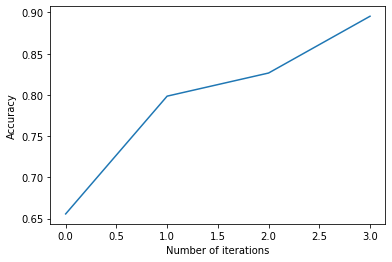

In [39]:
# Plot the accuracy versus the iteration number
plt.plot(accuracies)
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy")

## Summary

In this tutorial we saw how to embed *Argilla* in an active learning loop, and also how it can help you to **gather a sample efficient data set by annotating only the most decisive examples**. 
We created a rather minimalist active learning loop, but *Argilla* does not really care about the complexity of the loop. 
It will always help you to record and annotate data examples with their model predictions, allowing you to **quickly build up a data set from scratch**. 

## Bonus: Compare query strategies, random vs max uncertainty

In this bonus, we quickly demonstrate the effectiveness of annotating only the most uncertain predictions compared to random annotations.
So the next time you want to build a data set from scratch, keep this strategy in mind and maybe use *Argilla* for the annotation process! 😀

In [ ]:
n_iterations = 150
n_instances = 10
random_samples = 50


# Max uncertainty strategy
accuracies_max = []
for i in range(random_samples):
    train_rnd_df = train_df  # .sample(frac=1)
    test_rnd_df = test_df  # .sample(frac=1)
    X_rnd_train = vectorizer.transform(train_rnd_df.CONTENT)
    X_rnd_test = vectorizer.transform(test_rnd_df.CONTENT)

    accuracies, learner = [], ActiveLearner(estimator=MultinomialNB())

    for i in range(n_iterations):
        query_idx, _ = learner.query(X_rnd_train, n_instances=n_instances)
        learner.teach(
            X=X_rnd_train[query_idx], y=train_rnd_df.CLASS.iloc[query_idx].to_list()
        )
        accuracies.append(learner.score(X=X_rnd_test, y=test_rnd_df.CLASS))
    accuracies_max.append(accuracies)

# Random strategy
accuracies_rnd = []
for i in range(random_samples):
    accuracies, learner = [], ActiveLearner(estimator=MultinomialNB())

    for random_idx in np.random.choice(
        X_train.shape[0], size=(n_iterations, n_instances), replace=False
    ):
        learner.teach(
            X=X_train[random_idx], y=train_df.CLASS.iloc[random_idx].to_list()
        )
        accuracies.append(learner.score(X=X_test, y=test_df.CLASS))
    accuracies_rnd.append(accuracies)

arr_max, arr_rnd = np.array(accuracies_max), np.array(accuracies_rnd)

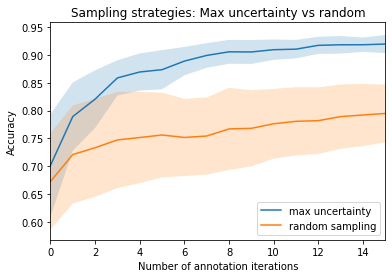

In [ ]:
plt.plot(range(n_iterations), arr_max.mean(0))
plt.fill_between(
    range(n_iterations),
    arr_max.mean(0) - arr_max.std(0),
    arr_max.mean(0) + arr_max.std(0),
    alpha=0.2,
)
plt.plot(range(n_iterations), arr_rnd.mean(0))
plt.fill_between(
    range(n_iterations),
    arr_rnd.mean(0) - arr_rnd.std(0),
    arr_rnd.mean(0) + arr_rnd.std(0),
    alpha=0.2,
)

plt.xlim(0, 15)
plt.title("Sampling strategies: Max uncertainty vs random")
plt.xlabel("Number of annotation iterations")
plt.ylabel("Accuracy")
plt.legend(["max uncertainty", "random sampling"], loc=4)

## Appendix: How did we obtain the train/test data?

In [ ]:
def load_data() -> pd.DataFrame:
    """
    Downloads the [YouTube Spam Collection](http://www.dt.fee.unicamp.br/~tiago//youtubespamcollection/)
    and returns the data as a tuple with a train and test DataFrame.
    """
    links, data_df = (
        [
            "http://lasid.sor.ufscar.br/labeling/datasets/9/download/",
            "http://lasid.sor.ufscar.br/labeling/datasets/10/download/",
            "http://lasid.sor.ufscar.br/labeling/datasets/11/download/",
            "http://lasid.sor.ufscar.br/labeling/datasets/12/download/",
            "http://lasid.sor.ufscar.br/labeling/datasets/13/download/",
        ],
        None,
    )

    with TemporaryDirectory() as tmpdirname:
        dfs = []
        for i, link in enumerate(links):
            file = Path(tmpdirname) / f"{i}.csv"
            request.urlretrieve(link, file)
            df = pd.read_csv(file)
            df["VIDEO"] = i
            dfs.append(df)
        data_df = pd.concat(dfs).reset_index(drop=True)

    train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)

    return train_df, test_df


train_df, test_df = load_data()
train_df.to_csv("data/active_learning/train.csv", index=False)
test_df.to_csv("data/active_learning/test.csv", index=False)